# JSSP comparação entre euristicas Classicas: tratamento dos dados 

In [1]:
# %pip install pandas
# %pip install seaborn
%pip install -r ../requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from classes.jssp import jssp
from classes.job import Jssp_job
import importlib.util
import os


In [3]:
def import_tests_cases(nome_dict : str) -> dict:

    caminho_absoluto = os.path.abspath("../tests/test1.py")

    spec = importlib.util.spec_from_file_location("modulo_temp", caminho_absoluto)
    
    if spec is None or spec.loader is None:
        raise ImportError(f"Não foi possível carregar o módulo do arquivo: {caminho_absoluto}")
    
    modulo = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(modulo)

    return getattr(modulo, nome_dict)
csv_filename = "simulated_annealing_results.csv"
df = pd.read_csv(csv_filename)


In [4]:
# Comparação entre timespan e fitness em porcentagem
print(f"\n{'='*50}")
print("COMPARAÇÃO TIMESPAN vs FITNESS (em %)")
print(f"{'='*50}")

timespan_ref = df['timespan'].iloc[0]
melhor_fitness = df['fitness'].min()
fitness_medio = df['fitness'].mean()
pior_fitness = df['fitness'].max()

print(f"Timespan de referência: {timespan_ref}")
print(f"\nAnálise do MELHOR fitness:")
print(f"Melhor fitness: {melhor_fitness:.2f}")
if timespan_ref > 0:
    diff_melhor = ((melhor_fitness - timespan_ref) / timespan_ref) * 100
    if diff_melhor <= 0:
        print(f"{abs(diff_melhor):.2f}% MELHOR que o timespan de referência")
    else:
        print(f"{diff_melhor:.2f}% PIOR que o timespan de referência")

print(f"\nAnálise do FITNESS MÉDIO:")
print(f"Fitness médio: {fitness_medio:.2f}")
if timespan_ref > 0:
    diff_medio = ((fitness_medio - timespan_ref) / timespan_ref) * 100
    if diff_medio <= 0:
        print(f"{abs(diff_medio):.2f}% MELHOR que o timespan de referência")
    else:
        print(f"{diff_medio:.2f}% PIOR que o timespan de referência")

print(f"\nAnálise do PIOR fitness:")
print(f"Pior fitness: {pior_fitness:.2f}")
if timespan_ref > 0:
    diff_pior = ((pior_fitness - timespan_ref) / timespan_ref) * 100
    if diff_pior <= 0:
        print(f"{abs(diff_pior):.2f}% MELHOR que o timespan de referência")
    else:
        print(f"{diff_pior:.2f}% PIOR que o timespan de referência")

# Estatísticas adicionais
print(f"\n{'='*50}")
print("ESTATÍSTICAS GERAIS")
print(f"{'='*50}")
execucoes_melhores = len(df[df['fitness'] <= timespan_ref])
total_execucoes = len(df)
porcentagem_melhores = (execucoes_melhores / total_execucoes) * 100

print(f"Execuções que atingiram/superaram o timespan: {execucoes_melhores}/{total_execucoes} ({porcentagem_melhores:.1f}%)")

# Distribuição de performance
fitness_values = df['fitness'].values
melhorias = []
for fitness in fitness_values:
    if timespan_ref > 0:
        melhoria = ((fitness - timespan_ref) / timespan_ref) * 100
        melhorias.append(melhoria)

melhorias = np.array(melhorias)
print(f"Melhoria média: {melhorias.mean():.3f}%")
print(f"Desvio padrão das melhorias: {melhorias.std():.3f}%")


COMPARAÇÃO TIMESPAN vs FITNESS (em %)
Timespan de referência: 10

Análise do MELHOR fitness:
Melhor fitness: 10.00
0.00% MELHOR que o timespan de referência

Análise do FITNESS MÉDIO:
Fitness médio: 10.40
4.00% PIOR que o timespan de referência

Análise do PIOR fitness:
Pior fitness: 11.00
10.00% PIOR que o timespan de referência

ESTATÍSTICAS GERAIS
Execuções que atingiram/superaram o timespan: 18/30 (60.0%)
Melhoria média: 4.000%
Desvio padrão das melhorias: 4.899%


id                                                              2036
execution_time                                              0.017316
fitness                                                         10.0
timespan                                                          10
solution_vector    [0.3548612600268034, 0.022653985292508505, 0.9...
Name: 3, dtype: object
Melhor solução encontrada: ['0.3548612600268034', '0.022653985292508505', '0.9134398114624968', '0.6899640644844923', '0.23838366041026215', '0.23054833401292008', '0.7071655790338794', '0.7231742486232624', '0.02033761598101813', '0.02993543065794535']


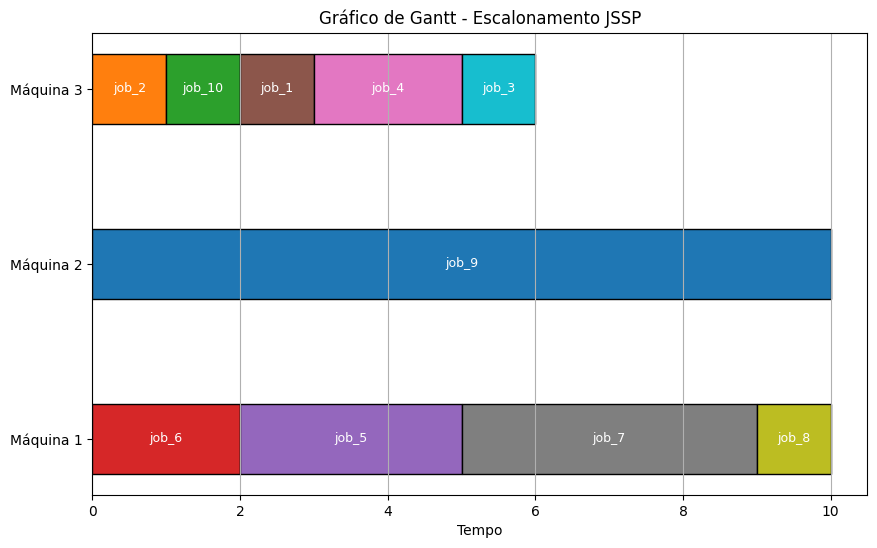

In [5]:
data = import_tests_cases("insane")
jssp_instance = jssp(data)


def simulate_schedule(solution_vec, operations):
    order = np.argsort(solution_vec)
    machine_available = {}
    job_available = {}
    schedule = []

    for idx in order:
        op = operations[idx]
        job = op["job"]
        machine = min(op["machines"], key=lambda m: machine_available.get(m, 0))

        start_time = max(machine_available.get(machine, 0), job_available.get(job, 0))
        end_time = start_time + op["duration"]

        machine_available[machine] = end_time
        job_available[job] = end_time

        schedule.append({
            "job": job,
            "machine": machine,
            "start": start_time,
            "end": end_time,
            "duration": op["duration"],
            "op_index": idx
        })

    return schedule

def plot_gantt(schedule):
    machines = sorted(set(op['machine'] for op in schedule))
    machine_to_y = {m: i for i, m in enumerate(machines)}

    fig, ax = plt.subplots(figsize=(10, 6))

    for op in schedule:
        start = op["start"]
        duration = op["duration"]
        machine = op["machine"]
        y = machine_to_y[machine]

        ax.barh(y, duration, left=start, height=0.4, align='center', edgecolor='black')

        ax.text(start + duration / 2, y, f"{op['job']}", 
                va='center', ha='center', color='white', fontsize=9)

    ax.set_yticks(range(len(machines)))
    ax.set_yticklabels([f"Máquina {m}" for m in machines])
    ax.set_xlabel("Tempo")
    ax.set_title("Gráfico de Gantt - Escalonamento JSSP")

    plt.grid(True, axis='x')
    plt.show()

best_solution = df[df['fitness'] == df['fitness'].min()].iloc[1]
print(best_solution)
a = best_solution["solution_vector"]
a = a.replace(" ", "")
a = a.replace("[", "")
a = a.replace("]", "")
a = a.split(",")

print(f"Melhor solução encontrada: {(a)}")
schedule = simulate_schedule(a, jssp_instance.get_flattened_operations())
plot_gantt(schedule)
